# Extracting Data from Grocery Receipts
Author: Dario Radečić @ Neos
***

- The goal of this notebook is to demonstrate how Python, OpenCV, and Tesseract can be used to extract pricing information from a scanned grocery receipt
- Make sure to install libraries listed in the `requirements.txt` file first:

```
pip install -r requirements.txt
```

- Also, make sure Tesseract-lang is installed on your system

In [1]:
import warnings
warnings.filterwarnings("ignore")

import re
import cv2
import pytesseract
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from IPython import display
display.set_matplotlib_formats("svg")  # For better in-notebook resolution

In [2]:
def show_image(image):
    plt.figure(figsize=(14, 8))
    # Turn off axes and axis ticks
    plt.axis("off")
    # Convert from BGR to RGB
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

<br>

## Image Transformations

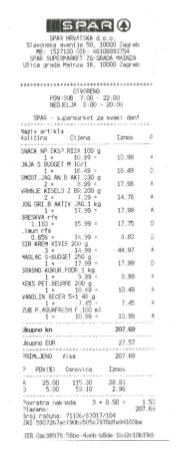

In [3]:
# Read and display the default image
im = cv2.imread("data/receipt.jpg")
show_image(im)

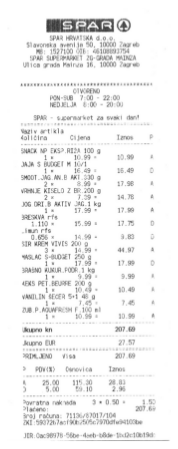

In [4]:
# Convert to grayscale - we don't need color info for extracting text from receipts
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
show_image(gray)

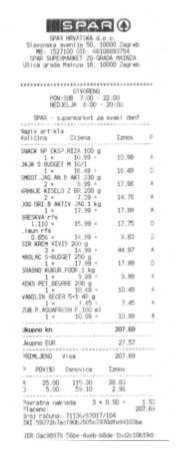

In [5]:
# Blur slighltly - allows for cleaner segmentation
blur = cv2.GaussianBlur(gray, (9, 9), 0)
show_image(blur)

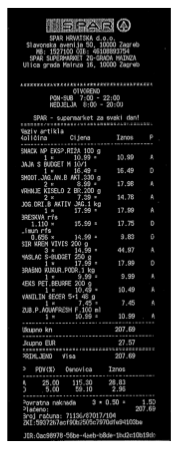

In [6]:
# Apply adaptive thresholding - feel free to play with pixel neighborhood size parameter (7)
# and c parameter (3) for different images to fine-tune the thresholding
thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 7, 3)
show_image(thresh)

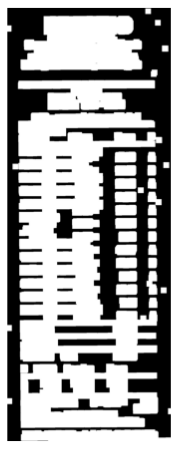

In [7]:
# Final step before finding contours
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
dilate = cv2.dilate(thresh, kernel, iterations=4)

show_image(dilate)

In [8]:
# Find contours
cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

<br>

# Segmenting the Receipt Image
- The goal is to find distinct areas in the receipt image
- The largest area should contain pricing data

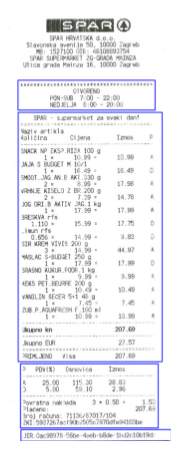

In [9]:
line_items_coordinates = []
for c in cnts:
    area = cv2.contourArea(c)
    x, y, w, h = cv2.boundingRect(c)

    if y >= 200 and x <= 1000:
        if area > 10000:
            image = cv2.rectangle(im, (x, y), (x + w, y + h), color=(255, 0, 0), thickness=3)
            line_items_coordinates.append([(x, y), (x + w, y + h)])
            
    
# The image will now have rectangles that mark distinct areas
show_image(image)

In [10]:
# Here are the coordinates --> [(x1, y1), (x2, y2)] --> Bottom left and top right corners
line_items_coordinates

[[(79, 2443), (948, 2511)],
 [(76, 2062), (870, 2434)],
 [(63, 606), (893, 2050)],
 [(62, 420), (852, 593)]]

- The rectangle with the largest surface area should be the one with the receipt data
- Let's see how to calculate the area:

In [11]:
# Coordinates
x1 = 79
y1 = 2443
x2 = 948
y2 = 2511

# Take the difference
x_diff = np.abs(x1 - x2)
y_diff = np.abs(y1 - y2)
x_diff, y_diff

(869, 68)

In [12]:
# Multiply it to get the area
x_diff * y_diff

59092

- Write it as a function that will automatically go over all items in `line_items_coordinates`
- Calculates and keeps track of the areas
- Returns argmax - index position of an item with the largest area:

In [13]:
def find_item_with_biggest_area(line_items_coordinates):
    areas = []
    for row in line_items_coordinates:
        x1, y1, x2, y2 = row[0][0], row[0][1], row[1][0], row[1][1]
        x_diff, y_diff = np.abs(x1 - x2), np.abs(y1 - y2)
        area = x_diff * y_diff
        areas.append(area)
        
    return np.argmax(areas)

In [14]:
find_item_with_biggest_area(line_items_coordinates)

2

In [15]:
line_items_coordinates[2]

[(63, 606), (893, 2050)]

- Let's tie everything so far in a single function:

In [16]:
def mark_regions(image_path: str):
    im = cv2.imread(image_path)
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9, 9), 0)
    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 7, 3)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
    dilate = cv2.dilate(thresh, kernel, iterations=4)
    cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    
    line_items_coordinates = []
    for c in cnts:
        area = cv2.contourArea(c)
        x, y, w, h = cv2.boundingRect(c)

        if y >= 200 and x <= 1000:
            if area > 10000:
                image = cv2.rectangle(im, (x, y), (x + w, y + h), color=(255, 0, 0), thickness=3)
                line_items_coordinates.append([(x, y), (x + w, y + h)])
                
    return image, line_items_coordinates

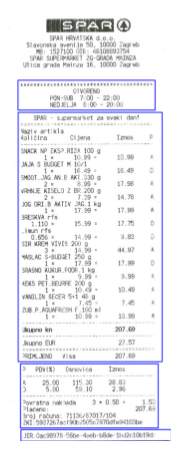

In [17]:
image, line_items_coordinates = mark_regions(image_path="data/receipt.jpg")
show_image(image)

<br><br>

## Extracting Pricing Data from the Receipt

- Extract the largest section first:

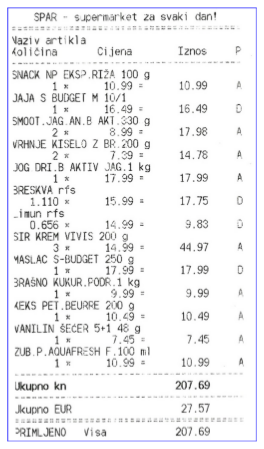

In [18]:
c = line_items_coordinates[find_item_with_biggest_area(line_items_coordinates)]

invoice_item_section = image[c[0][1]:c[1][1], c[0][0]:c[1][0]]
show_image(invoice_item_section)

- Apply some preprocessing operations:

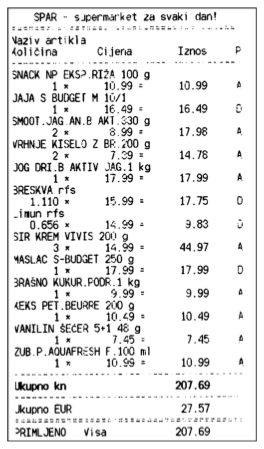

In [19]:
gray = cv2.cvtColor(invoice_item_section, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)
ret, thresh1 = cv2.threshold(blur, 190, 255, cv2.THRESH_BINARY)
show_image(thresh1)

- Use Tesseract to extract text from the image:

In [20]:
text = str(pytesseract.image_to_string(thresh1, config="--psm 6"))
print(text)

SPAR ~- supermarket za svaki dan!
Naziv artikla
dolicina Cijena Iznos F
SNACK NP EKS?.RIZA 100 g
1 x 10.99 = 10.99 A
JAJA S BUDGET M 10/1
1 x 16.49 = 16.49 o
SMOOT.JAG.AN.B AKT.330 g
2 * 3.99 = 17.98 A
VRHNJE KISELD Z BE.200 g
2* 7.39 = 14.78 A
JOG DRI.B AKTIV JAG.1 kg
1 x 17.99 = 17.99 A
3RESKVA ris
1.110 x 15.99 = 17.75 G
_imun rfs
0.656 x 14.99 = 9.83 ub
SIR KREM VIVIS 200 g
3x 14.99 = 44.97 A
MASLAC S-BUDGET 250 9
1x 17.99 = 17.99 5)
3RASNO KUKUR.FODR.1 kg
1x 9.99 = 9.99 4
AEKS PET .BEURRE 2010 9
1 «x 10.49 = 10.49 A
VANILIN SECER 5+1 48 g
1 x 7.45 = 7.45 A
ZUB.P.AQUAFR=SH F.100 ml
1 x 10.99 = 10.99 A
Ukupno kn 207.69
Jkupno EUR 27.57
RIMLJENO 3 Visa 207 .69



- There is an unwanted character - « - The `remove_unwanted_chars()` function will remove it
- Feel free to add additional characters to the `blacklist_chars` list:

In [21]:
def remove_unwanted_chars(text: str) -> list:
    out = []
    blacklist_chars = ["«"]
    lines = text.split("\n")
    
    for line in lines:
        l = line
        for b_char in blacklist_chars:
            l = l.replace(b_char, "")
        out.append(l)
        
    return out

- Text is now formatted as a list where each list item is a single line of text:

In [22]:
new_text = remove_unwanted_chars(text)
new_text

['SPAR ~- supermarket za svaki dan!',
 'Naziv artikla',
 'dolicina Cijena Iznos F',
 'SNACK NP EKS?.RIZA 100 g',
 '1 x 10.99 = 10.99 A',
 'JAJA S BUDGET M 10/1',
 '1 x 16.49 = 16.49 o',
 'SMOOT.JAG.AN.B AKT.330 g',
 '2 * 3.99 = 17.98 A',
 'VRHNJE KISELD Z BE.200 g',
 '2* 7.39 = 14.78 A',
 'JOG DRI.B AKTIV JAG.1 kg',
 '1 x 17.99 = 17.99 A',
 '3RESKVA ris',
 '1.110 x 15.99 = 17.75 G',
 '_imun rfs',
 '0.656 x 14.99 = 9.83 ub',
 'SIR KREM VIVIS 200 g',
 '3x 14.99 = 44.97 A',
 'MASLAC S-BUDGET 250 9',
 '1x 17.99 = 17.99 5)',
 '3RASNO KUKUR.FODR.1 kg',
 '1x 9.99 = 9.99 4',
 'AEKS PET .BEURRE 2010 9',
 '1 x 10.49 = 10.49 A',
 'VANILIN SECER 5+1 48 g',
 '1 x 7.45 = 7.45 A',
 'ZUB.P.AQUAFR=SH F.100 ml',
 '1 x 10.99 = 10.99 A',
 'Ukupno kn 207.69',
 'Jkupno EUR 27.57',
 'RIMLJENO 3 Visa 207 .69',
 '']

- What we want is, for example, "1 x 10.99 = 10.99 A"
- This row tells us how many items were bought at which unit price and what is the total price
- There are some characters that make the extraction more challenging, so we'll remove them

In [23]:
def extract_from_pricing_info(pricing_info: str) -> dict:
    replace_chars = {"*": "", "x": "", "=": ""}
    
    for key, value in replace_chars.items():
        pricing_info = pricing_info.replace(key, value)
      
    items = pricing_info.split()
    
    return {
        "quantity": float(items[0]),
        "unit_price": float(items[1]),
        "total_price": float(items[2])
    }


print(extract_from_pricing_info("1 x 10.99 = 10.99 A"))
print(extract_from_pricing_info("2* 7.39 = 14.78 A"))
print(extract_from_pricing_info("1.110 x 15.99 = 17.75 G"))

{'quantity': 1.0, 'unit_price': 10.99, 'total_price': 10.99}
{'quantity': 2.0, 'unit_price': 7.39, 'total_price': 14.78}
{'quantity': 1.11, 'unit_price': 15.99, 'total_price': 17.75}


- It works, so let's now extract both the item bought and its pricing info
- The regular expression matches both integer or a floating point number followed by an optional whitespace and then followed by either * or x signs - sometimes Tesseract gets it wrong:
- If there's a match, both that row and the row before it are extracted
    - The row before contains item name

In [24]:
price_pattern = r"^\d*(\.\d+)?\s?[*x]"
extracted = []

for ind, row in enumerate(new_text):
    if re.search(price_pattern, row) is not None:
        item = new_text[ind-1]
        price_info = new_text[ind]
        pricing_info = extract_from_pricing_info(price_info)
        
        extracted.append({
            "item": item,
            **pricing_info
        })
        
extracted

[{'item': 'SNACK NP EKS?.RIZA 100 g',
  'quantity': 1.0,
  'unit_price': 10.99,
  'total_price': 10.99},
 {'item': 'JAJA S BUDGET M 10/1',
  'quantity': 1.0,
  'unit_price': 16.49,
  'total_price': 16.49},
 {'item': 'SMOOT.JAG.AN.B AKT.330 g',
  'quantity': 2.0,
  'unit_price': 3.99,
  'total_price': 17.98},
 {'item': 'VRHNJE KISELD Z BE.200 g',
  'quantity': 2.0,
  'unit_price': 7.39,
  'total_price': 14.78},
 {'item': 'JOG DRI.B AKTIV JAG.1 kg',
  'quantity': 1.0,
  'unit_price': 17.99,
  'total_price': 17.99},
 {'item': '3RESKVA ris',
  'quantity': 1.11,
  'unit_price': 15.99,
  'total_price': 17.75},
 {'item': '_imun rfs',
  'quantity': 0.656,
  'unit_price': 14.99,
  'total_price': 9.83},
 {'item': 'SIR KREM VIVIS 200 g',
  'quantity': 3.0,
  'unit_price': 14.99,
  'total_price': 44.97},
 {'item': 'MASLAC S-BUDGET 250 9',
  'quantity': 1.0,
  'unit_price': 17.99,
  'total_price': 17.99},
 {'item': '3RASNO KUKUR.FODR.1 kg',
  'quantity': 1.0,
  'unit_price': 9.99,
  'total_price': 

- Now convert it into a more readable format - Pandas DataFrame - and assign an additional line number column:

In [25]:
df = pd.DataFrame(extracted)
df.insert(0, "#", range(1, len(df) + 1))
df

,#,item,quantity,unit_price,total_price
0,1,SNACK NP EKS?.RIZA 100 g,1.000,10.99,10.99
1,2,JAJA S BUDGET M 10/1,1.000,16.49,16.49
2,3,SMOOT.JAG.AN.B AKT.330 g,2.000,3.99,17.98
3,4,VRHNJE KISELD Z BE.200 g,2.000,7.39,14.78
4,5,JOG DRI.B AKTIV JAG.1 kg,1.000,17.99,17.99
5,6,3RESKVA ris,1.110,15.99,17.75
6,7,_imun rfs,0.656,14.99,9.83
7,8,SIR KREM VIVIS 200 g,3.000,14.99,44.97
8,9,MASLAC S-BUDGET 250 9,1.000,17.99,17.99
9,10,3RASNO KUKUR.FODR.1 kg,1.000,9.99,9.99


- The DataFrame can be styled further:

In [26]:
headers = {
    "selector": "th:not(.index_name)",
    "props": "background-color: #171f3d; color: white; text-align: center; text-transform: uppercase;"
}
gen_properties = {"border": "1px solid black", "width": "80px", "height": "30px", "text-align": "center"}
item_properties = {"width": "250px"}
item_no_properties = {"width": "30px", "font-weight": "bold"}

(df.style
     .format(precision=2)
     .set_table_styles([headers])
     .set_properties(**gen_properties)
     .set_properties(subset=["#"], **item_no_properties)
     .set_properties(subset=["item"], **item_properties)
     .hide(axis="index")
)

#,item,quantity,unit_price,total_price
1,SNACK NP EKS?.RIZA 100 g,1.00,10.99,10.99
2,JAJA S BUDGET M 10/1,1.00,16.49,16.49
3,SMOOT.JAG.AN.B AKT.330 g,2.00,3.99,17.98
4,VRHNJE KISELD Z BE.200 g,2.00,7.39,14.78
5,JOG DRI.B AKTIV JAG.1 kg,1.00,17.99,17.99
6,3RESKVA ris,1.11,15.99,17.75
7,_imun rfs,0.66,14.99,9.83
8,SIR KREM VIVIS 200 g,3.00,14.99,44.97
9,MASLAC S-BUDGET 250 9,1.00,17.99,17.99
10,3RASNO KUKUR.FODR.1 kg,1.00,9.99,9.99
